In [1]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, r2_score, brier_score_loss, f1_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier, XGBRegressor
import shap
from skopt import BayesSearchCV
import skopt.space as space
import skopt.plots as plots
import imblearn
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE
from ff_custom_scripts import *

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.impute import KNNImputer

from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score


In [2]:
train, test,leaderboard,holdout = load_files(nanvalues='remove')

alldata = pd.concat([train, test]) # all data available for training in the FF Challenge

print(train.shape, test.shape,leaderboard.shape,holdout.shape)

meta = pd.read_csv('../metadata/metadata.csv', index_col=0)


(1172, 10396) (294, 10396) (530, 10396) (803, 10396)


In [3]:
meta.head(5)

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
cf1lenhr,What was the total length of interview - Hours,Continuous,paradata_and_weights,float64,0.000000,0.009892,0.003785,0.000000,0.007810,0.000000
cf1lenmin,What was the total length of interview - Minutes,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.001409,0.000000,0.000000
cf1fint,Constructed - Was father interviewed at baseline?,Binary,paradata_and_weights,object,0.021894,0.018859,0.016743,0.028699,0.000000,0.000000
cf1citsm,Constructed - Baseline city sample flag,Binary,paradata_and_weights,object,0.012485,0.023336,0.011364,0.000000,0.016590,0.004293
f1citywt,Father baseline city sample weight (20-cities ...,Continuous,paradata_and_weights,float64,0.000000,0.000000,0.000000,0.009234,0.002574,0.014284


In [4]:
targets = ['gpa','grit','materialHardship','eviction','layoff','jobTraining']

predictors = {target: list(meta[meta[target] != 0].index) for target in targets}

# Model

In [5]:
import lightgbm as lgb

In [6]:
def run_model(train, target='gpa', classifier=False):
    X_train, y_train = prepare_data(train, target)
    
    categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    ordered_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('target', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ])

    numerical_features = cols_per_type(X_train, 'Continuous')
    categorical_features = cols_per_type(X_train, 'Categorical')
    binary_features = cols_per_type(X_train, 'Binary')
    ordinal_features = cols_per_type(X_train, 'Ordinal')
    
    preprocessor = make_column_transformer(
        (categorical_transformer, categorical_features),
        ('passthrough', numerical_features),
        (ordered_transformer, ordinal_features),
        (ordered_transformer, binary_features)
    )
    
    search_space = {
            'regressor__n_estimators': space.Integer(600, 1500),
            'regressor__learning_rate': space.Real(0.01, 0.06),
            'regressor__max_depth': space.Integer(5, 10),
            'regressor__min_child_weight': space.Integer(3, 5),
            'regressor__subsample': space.Real(0.5, 0.8),
        }
    
    if classifier:
        score = 'neg_brier_score'
        lightgbm = lgb.LGBMClassifier(n_jobs=-1, objective='binary', metric='binary_logloss')
        search_space.update({'regressor__scale_pos_weight': space.Integer(2, 17)})
           
    else:
        lightgbm = lgb.LGBMRegressor(n_jobs=-1, objective='regression', metric='rmse')
        score = 'neg_mean_squared_error'
    
        
    pipes = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regressor', lightgbm)])
                            
    model = BayesSearchCV(
        pipes,
        search_space,
        n_iter=20,
        cv=5,
        n_jobs=-1,
        scoring=score,
        refit=True,
        verbose=0,
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    return model

In [7]:
def score_model(model, target, test, leaderboard, holdout, classifier=False):
    # Get CV score
    score = -model.best_score_
    print(f'Best CV score: {score:.4f}')
    
    # Get mean CV score
    mean_score = -model.cv_results_['mean_test_score'].mean()
    print(f'Mean CV score: {mean_score:.4f}')
    
    # Prepare test data
    X_test, y_test = prepare_data(test, target)

    if classifier:
        # Compute test scores
        y_pred = model.predict(X_test)
        brier = brier_score_loss(y_test, y_pred)
        f1 = f1_score(y_test, y_pred.round())
        
        # Print test scores
        print(f'Test Brier: {brier:.4f}')
        print(f'Test F1: {f1:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        y_pred = model.predict(X_leaderboard)
        brier = brier_score_loss(y_leaderboard, y_pred)
        f1 = f1_score(y_leaderboard, y_pred.round())

        # # Print leaderboard scores
        print(f'Leaderboard Brier: {brier:.4f}')
        print(f'Leaderboard F1: {f1:.4f}')

        # # # Compute holdout scores
        # X_holdout, y_holdout = prepare_data(holdout, target)
        # y_pred = model.predict(X_holdout)
        # y_holdout = y_holdout.astype(int)
        # brier = brier_score_loss(y_holdout, y_pred)
        # print(f'Holdout Brier: {brier:.4f}')
        
        
    else:
        # Compute test scores
        mse = mean_squared_error(y_test, model.predict(X_test))
        rsquared = r2_score(y_test, model.predict(X_test))
        
        # Print test scores
        print(f'Test MSE: {mse:.4f}')
        print(f'Test R2: {rsquared:.4f}')

        # # Compute leaderboard scores
        X_leaderboard, y_leaderboard = prepare_data(leaderboard, target)
        mse = mean_squared_error(y_leaderboard, model.predict(X_leaderboard))
        rsquared = r2_score(y_leaderboard, model.predict(X_leaderboard))

        # Print leaderboard scores
        print(f'Leaderboard MSE: {mse:.4f}')
        print(f'Leaderboard R2: {rsquared:.4f}')

        # # Compute holdout scores
        X_holdout, y_holdout = prepare_data(holdout, target)
        # X_holdout_transformed = model.best_estimator_.named_steps['preprocessor'].transform(X_holdout)
        mse = mean_squared_error(y_holdout, model.predict(X_holdout))
        rsquared = r2_score(y_holdout, model.predict(X_holdout))

        # Print holdout scores
        print(f'Holdout MSE: {mse:.4f}')
        print(f'Holdout R2: {rsquared:.4f}')
        
def shap_show(model, alldata, target, n=5):
    X, y = prepare_data(alldata, target)
    model  = model.best_estimator_.fit(X, y)
    Xtransform = model.named_steps['preprocessor'].transform(X)
    exp = shap.TreeExplainer(model.named_steps['regressor'])
    transformer = model.named_steps['preprocessor']
    names = transformer.get_feature_names_out()
    featnames = [splitfeatname(name) for name in names]
    shap_values = exp.shap_values(Xtransform)
    # get top n features
    top_n_idx = np.argsort(np.abs(shap_values).mean(0))[-n:]
    top_n_feat = [featnames[i] for i in top_n_idx]
    # # get questions
    top_n_vars = [meta[meta.index.isin([feat])].varlab.values for feat in top_n_feat]
    # # reverse order
    top_n_vars = top_n_vars[::-1]
    shap.summary_plot(shap_values, Xtransform, max_display=n, feature_names=featnames)
    return dict(zip(map(tuple, top_n_vars), top_n_feat))


# GPA

In [8]:
gpa_model = run_model(train,target='gpa', classifier=False)

In [9]:
gpa_model.best_params_

OrderedDict([('regressor__learning_rate', 0.01142998126447393),
             ('regressor__max_depth', 7),
             ('regressor__min_child_weight', 3),
             ('regressor__n_estimators', 727),
             ('regressor__subsample', 0.5001122115963416)])

In [10]:
score_model(gpa_model,'gpa',test,leaderboard,holdout,classifier=False)

Best CV score: 0.4005
Mean CV score: 0.4091
Test MSE: 0.4726
Test R2: 0.0089
Leaderboard MSE: 0.5414
Leaderboard R2: -0.3861
Holdout MSE: 0.5676
Holdout R2: -0.3444


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


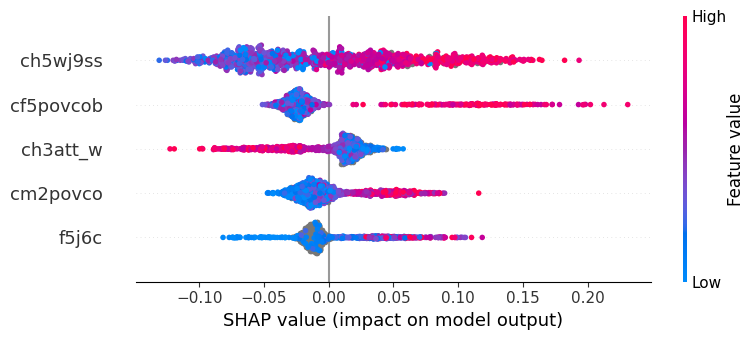

{('Woodcock Johnson Test 9 standard score',): 'f5j6c',
 ("Constructed - father's household income/poverty threshold at 9-year, mother repo",): 'cm2povco',
 ('attention-seeking',): 'ch3att_w',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'cf5povcob',
 ('J6C. Value of vehicle if sold',): 'ch5wj9ss'}

In [11]:
shap_show(gpa_model, alldata, target='gpa')

# Material Hardship

In [12]:
model_materialHardship = run_model(train,target='materialHardship', classifier=False)

In [13]:
model_materialHardship.best_params_

OrderedDict([('regressor__learning_rate', 0.010181515362737162),
             ('regressor__max_depth', 9),
             ('regressor__min_child_weight', 4),
             ('regressor__n_estimators', 829),
             ('regressor__subsample', 0.6735993008685155)])

In [14]:

score_model(model_materialHardship, target='materialHardship', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.0203
Mean CV score: 0.0207
Test MSE: 0.0221
Test R2: 0.1252
Leaderboard MSE: 0.0352
Leaderboard R2: -0.2290
Holdout MSE: 0.0317
Holdout R2: -0.3005


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


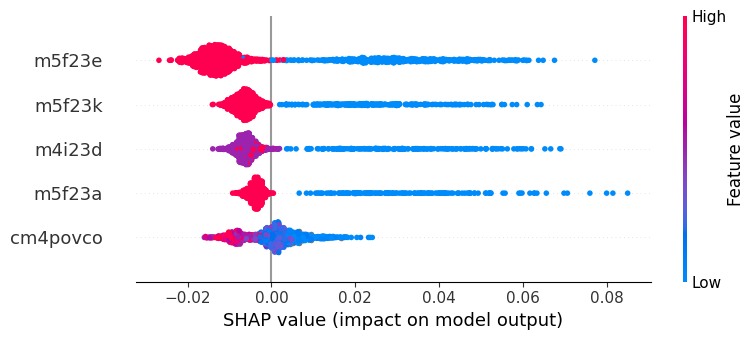

{('F23E. Did not pay full amount of gas/oil/electricity bill in past 12 months',): 'cm4povco',
 ("F23K. Telephone service disconnected because wasn't enough money in past 12 mont",): 'm5f23a',
 ("In past year, did not pay full amt rent/mortgage payments b/c wasn't enough",): 'm4i23d',
 ('F23A. Received free food or meals in past 12 months',): 'm5f23k',
 ("Constructed - Poverty ratio - mother's household income/poverty threshold",): 'm5f23e'}

In [15]:
shap_show(model_materialHardship, alldata, target='materialHardship')

# Grit


In [16]:
model_grit = run_model(train,target='grit', classifier=False)

In [17]:
model_grit.best_params_

OrderedDict([('regressor__learning_rate', 0.0101242749707214),
             ('regressor__max_depth', 9),
             ('regressor__min_child_weight', 3),
             ('regressor__n_estimators', 602),
             ('regressor__subsample', 0.789996668663659)])

In [18]:
score_model(model_grit, target='grit', test=test, leaderboard=leaderboard, holdout=holdout, classifier=False)

Best CV score: 0.2506
Mean CV score: 0.2561
Test MSE: 0.2477
Test R2: -0.0722
Leaderboard MSE: 0.2809
Leaderboard R2: -0.2782
Holdout MSE: 0.2935
Holdout R2: -0.2284


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


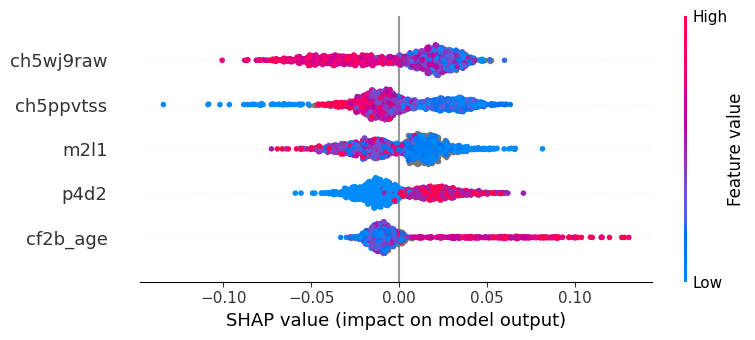

{('Woodcock Johnson Test 9 raw score',): 'cf2b_age',
 ('PPVT standard score',): 'p4d2',
 ('What was your total household income before taxes last year, all sources?',): 'm2l1',
 ("D2. INTERVIEWER CHECK: Any of d1a-d1e coded 'often true' or 'sometimes true'?",): 'ch5ppvtss',
 ("Constructed - Baby's age at time of father's one-year interview (months)",): 'ch5wj9raw'}

In [19]:
shap_show(model_grit, alldata, target='grit')

In [20]:
meta[meta.index=='m5a8f01']

,varlab,type,one_topic,dtype,gpa,grit,materialHardship,eviction,layoff,jobTraining
new_name,,,,,,,,,,
m5a8f01,A8F. Your relationship with the father at biol...,Ordered Categorical,romantic_relationships,category,0.0,0.0,0.026602,0.0,0.0,0.0


# Eviction

In [21]:
model_eviction = run_model(train,target='eviction', classifier=True)

In [22]:
score_model(model_eviction, 'eviction', test, leaderboard, holdout, classifier=True)

Best CV score: 0.0570
Mean CV score: 0.0580
Test Brier: 0.0548
Test F1: 0.0000
Leaderboard Brier: 0.0679
Leaderboard F1: 0.0526
Holdout Brier: 0.0847


In [24]:
# shap_show(model_eviction, alldata, target='eviction')

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


TypeError: only integer scalar arrays can be converted to a scalar index

In [ ]:
# top5 = ['m5f23k','p3m39','m5i3c']

# meta[meta.index.isin(top5)].varlab.values

# jobTraining

In [25]:
model_job = run_model(train,target='jobTraining', classifier=True)

In [29]:
score_model(model_job,'jobTraining',test,leaderboard,holdout,classifier=True)

Best CV score: 0.1876
Mean CV score: 0.2083
Test Brier: 0.2226
Test F1: 0.2169
Leaderboard Brier: 0.3340
Leaderboard F1: 0.1106
Holdout Brier: 0.3225


In [30]:
# shap_show(model_job, alldata, target='jobTraining')

In [31]:
top5 = ['m5i2_1','p5l13f','cm5hhinc']

meta[meta.index.isin(top5)].varlab.values

array(['I2_1. Attending regular high school',
       'L13F. Gifted and talented program',
       "Constructed - Mother's Household income (with imputed values)"],
      dtype=object)

# Layoff

In [32]:
model_layoff = run_model(train, target='layoff', classifier=True)

In [33]:
model_layoff.best_params_

OrderedDict([('regressor__learning_rate', 0.01),
             ('regressor__max_depth', 5),
             ('regressor__min_child_weight', 5),
             ('regressor__n_estimators', 600),
             ('regressor__scale_pos_weight', 2),
             ('regressor__subsample', 0.8)])

In [34]:
score_model(model_layoff, 'layoff', test, leaderboard, holdout, classifier=True)

Best CV score: 0.1829
Mean CV score: 0.1985
Test Brier: 0.2248
Test F1: 0.0000
Leaderboard Brier: 0.2509
Leaderboard F1: 0.1307
Holdout Brier: 0.2441


In [35]:
# shap_show(model_layoff, alldata, target='layoff')